In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

import pandas as pd
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'

# !unzip -qq '/파일 경로/파일명.zip' -d '저장할 dir 위치 경로'
#!unzip -qq '/content/drive/MyDrive/Colab Notebooks/fsi/open/sample_submission.zip' -d '/content/drive/MyDrive/Colab Notebooks/fsi/open/'

In [ ]:
sample_sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fsi/open/syn_submission.csv')
made_sample_sub = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fsi/open/made_syn_submission.csv')

In [ ]:
cols = sample_sub.columns

In [ ]:
for x in cols:
    if made_sample_sub[x].dtype != sample_sub[x].dtype:
        print(x)

In [ ]:
# 정보 확인
made_sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13000 entries, 0 to 12999
Data columns (total 63 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Customer_Birthyear                             13000 non-null  int64  
 1   Customer_Gender                                13000 non-null  object 
 2   Customer_personal_identifier                   13000 non-null  object 
 3   Customer_identification_number                 13000 non-null  object 
 4   Customer_registration_datetime                 13000 non-null  object 
 5   Customer_credit_rating                         13000 non-null  object 
 6   Customer_flag_change_of_authentication_1       13000 non-null  int64  
 7   Customer_flag_change_of_authentication_2       13000 non-null  int64  
 8   Customer_flag_change_of_authentication_3       13000 non-null  int64  
 9   Customer_flag_change_of_authentication_4       130

In [ ]:
# 데이터 읽기
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'

train_all = pd.read_csv(path + "train.csv")
test_all = pd.read_csv(path + "test.csv")

train = train_all.drop(columns="ID")

train["Fraud_Type"].value_counts()

,count
Fraud_Type,
m,118800
a,100
j,100
h,100
k,100
c,100
g,100
i,100
b,100


In [ ]:
# 결측치 및 정보 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 63 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   Customer_Birthyear                             120000 non-null  int64  
 1   Customer_Gender                                120000 non-null  object 
 2   Customer_personal_identifier                   120000 non-null  object 
 3   Customer_identification_number                 120000 non-null  object 
 4   Customer_registration_datetime                 120000 non-null  object 
 5   Customer_credit_rating                         120000 non-null  object 
 6   Customer_flag_change_of_authentication_1       120000 non-null  int64  
 7   Customer_flag_change_of_authentication_2       120000 non-null  int64  
 8   Customer_flag_change_of_authentication_3       120000 non-null  int64  
 9   Customer_flag_change_of_authenticatio

In [ ]:
# 음수 형태
train.loc[13972, 'Time_difference']

'-5 days +18:01:39'

In [ ]:
# 반례 사례 확인
print(train[train['Transaction_Datetime'] <= train['Account_creation_datetime']][['Transaction_Datetime', 'Account_creation_datetime']])
print(train[train['Transaction_Datetime'] <= train['Last_atm_transaction_datetime']][['Transaction_Datetime', 'Last_atm_transaction_datetime']])
print(train[train['Transaction_Datetime'] <= train['Last_bank_branch_transaction_datetime']][['Transaction_Datetime', 'Last_bank_branch_transaction_datetime']])
print(train[train['Last_atm_transaction_datetime'] < train['Account_creation_datetime']][['Last_atm_transaction_datetime', 'Account_creation_datetime']])
print(train[train['Last_bank_branch_transaction_datetime'] < train['Account_creation_datetime']][['Last_bank_branch_transaction_datetime', 'Account_creation_datetime']])

Empty DataFrame
Columns: [Transaction_Datetime, Account_creation_datetime]
Index: []
Empty DataFrame
Columns: [Transaction_Datetime, Last_atm_transaction_datetime]
Index: []
Empty DataFrame
Columns: [Transaction_Datetime, Last_bank_branch_transaction_datetime]
Index: []
Empty DataFrame
Columns: [Last_atm_transaction_datetime, Account_creation_datetime]
Index: []
Empty DataFrame
Columns: [Last_bank_branch_transaction_datetime, Account_creation_datetime]
Index: []


In [ ]:
# time_difference를 초로 바꾸기
train['Time_difference_seconds'] = pd.to_timedelta(train['Time_difference']).dt.total_seconds()

# 거래 시간대 나누기
def convert_timeline(hour):
    if 0 <= hour < 6:
        return 0 #새벽
    elif 6 <= hour < 12:
        return 1 #오전
    elif 12 <= hour < 18:
        return 2 #오후
    else:
        return 3 #저녁
train['transaction_time_of_day'] = pd.to_datetime(train['Transaction_Datetime']).dt.hour.apply(convert_timeline)


# 최근 ATM 거래 이후의 시간 차이 (분)
train['Minutes_since_last_ATM'] = (pd.to_datetime(train['Transaction_Datetime']) - pd.to_datetime(train['Last_atm_transaction_datetime'])).dt.total_seconds() / 60

# 계좌 재개 이후 거래 까지의 시간 차이 (분)
train['Minutes_since_resumed'] = (pd.to_datetime(train['Transaction_Datetime']) - pd.to_datetime(train['Transaction_resumed_date'])).dt.total_seconds() / 60

# 최근 영업점 거래 이후의 시간 차이 (분)
train['Minutes_since_last_branch'] = (pd.to_datetime(train['Transaction_Datetime']) - pd.to_datetime(train['Last_bank_branch_transaction_datetime'])).dt.total_seconds() / 60

In [ ]:
# 이진형 - 범주형: 상관관계 파악 -> 특이 사항 없음

import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np
# 샘플 데이터 생성
binary_cols = ['Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3',
               'Customer_flag_change_of_authentication_4','Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator',
               'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3',
               'Customer_flag_terminal_malicious_behavior_4', 'Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6',
               'Customer_inquery_atm_limit', 'Customer_increase_atm_limit', 'Account_indicator_release_limit_excess', 'Account_indicator_Openbanking',
               'Account_release_suspention', 'Transaction_Failure_Status', 'Another_Person_Account', 'Unused_terminal_status', 'First_time_iOS_by_vulnerable_user',
               'Flag_deposit_more_than_tenMillion', 'Unused_account_status', 'Recipient_account_suspend_status', 'transaction_time_of_day'
               ]

for x in binary_cols:
    df = pd.DataFrame(train)

    # 교차표 생성
    contingency_table = pd.crosstab(train[x], train['Fraud_Type'])

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Cramér's V 계산
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    cramers_v = np.sqrt(phi2 / min(r-1, k-1))
    if p < 0.05 and cramers_v>=0.1:
        print(x)
        print(f"Chi-squared: {chi2}")
        print(f"p-value: {p}")
        print(f"Cramér's V: {cramers_v}")
        print("------------------------------")

In [ ]:
# 범주형 - 범주형: 상관관계 파악 -> 특이 사항 없음

cate_cols = ['Customer_Gender', 'Customer_personal_identifier', 'Customer_identification_number', 'Customer_credit_rating',
             'Customer_loan_type', 'Account_account_number', 'Account_account_type', 'Channel', 'Operating_System', 'Error_Code',
             'Type_General_Automatic', 'IP_Address', 'MAC_Address', 'Access_Medium', 'Location', 'Recipient_Account_Number',
             ]
for x in binary_cols:
    df = pd.DataFrame(train)

    # 교차표 생성
    contingency_table = pd.crosstab(train[x], train['Fraud_Type'])

    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Cramér's V 계산
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    cramers_v = np.sqrt(phi2 / min(r-1, k-1))
    if p < 0.05 and cramers_v>=0.1:
        print(x)
        print(f"Chi-squared: {chi2}")
        print(f"p-value: {p}")
        print(f"Cramér's V: {cramers_v}")
        print("------------------------------")

In [ ]:
# 설치
!pip install pingouin

In [ ]:
import pingouin as pg

num_cols = ['Customer_Birthyear', 'Account_initial_balance', 'Account_balance', 'Account_amount_daily_limit',
            'Account_remaining_amount_daily_limit_exceeded', 'Account_one_month_max_amount', 'Account_one_month_std_dev',
            'Account_dawn_one_month_max_amount', 'Account_dawn_one_month_std_dev', 'Transaction_Amount', 'Distance',
            'Number_of_transaction_with_the_account', 'Transaction_history_with_the_account', 'Transaction_num_connection_failure',
            'Minutes_since_last_ATM', 'Minutes_since_resumed', 'Minutes_since_last_branch', 'Time_difference_seconds'
            ]

# 각 그룹별로 데이터 나누기
for x in num_cols:
    df = train[[x, 'Fraud_Type']]

    # ANOVA 수행
    anova = pg.anova(dv=x, between='Fraud_Type', data=train, detailed=True)
    # p-unc와 np2 추출
    p_value = anova['p-unc'].values[0]
    eta_squared = anova['np2'].values[0]

    # 결과 출력
    if p_value < 0.05 and eta_squared >= 0.01:
        print(x)
        print("p-unc (p-value):", p_value)
        print("np2 (Eta Squared):", eta_squared)
        print("-------------------------")

Transaction_Amount
p-unc (p-value): 0.0
np2 (Eta Squared): 0.014537897398632812
-------------------------


In [ ]:
import pandas as pd

# IQR을 이용한 이상치 처리 함수 정의
def replace_outliers_with_median(df, group_column, target_column):
    def replace_outliers(group):
        Q1 = group[target_column].quantile(0.25)
        Q3 = group[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 중앙값 계산
        median_value = group[target_column].median()

        # 이상치를 중앙값으로 대체
        group[target_column] = group[target_column].apply(
            lambda x: median_value if x < lower_bound or x > upper_bound else x
        )

        return group

    # 그룹별로 함수 적용
    df_cleaned = df.groupby(group_column, group_keys=False).apply(replace_outliers).reset_index(drop=True)

    return df_cleaned

# Transaction_Amount에 대해 Fraud_Type별로 이상치 처리
train_df = replace_outliers_with_median(train, 'Fraud_Type', 'Transaction_Amount')

BEFORE


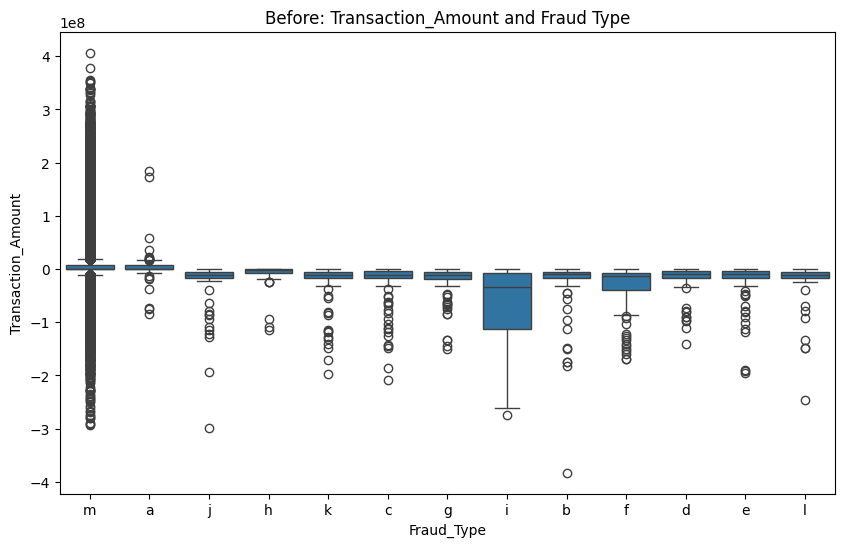

AFTER


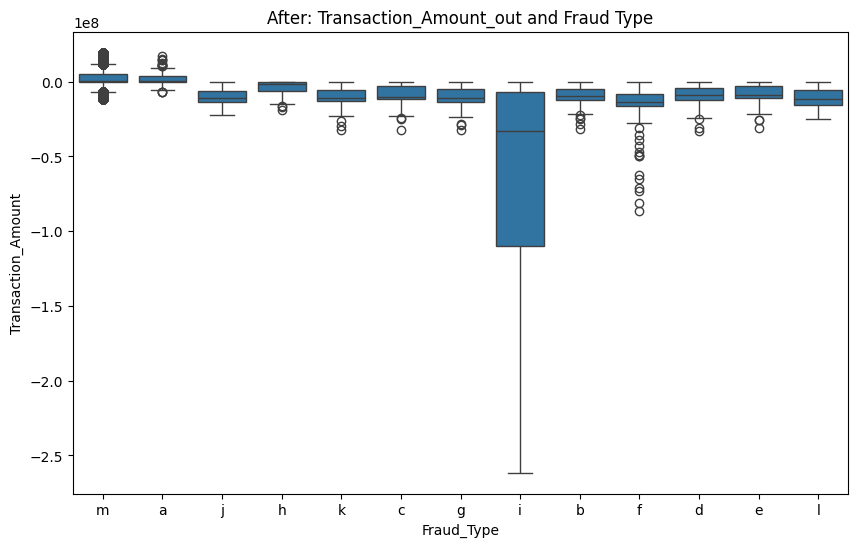

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# IQR을 이용한 이상치 처리 함수 정의
def replace_outliers_with_median(df, group_column, target_column):
    def replace_outliers(group):
        Q1 = group[target_column].quantile(0.25)
        Q3 = group[target_column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # 중앙값 계산
        median_value = group[target_column].median()

        # 이상치를 중앙값으로 대체
        group[target_column] = group[target_column].apply(
            lambda x: median_value if x < lower_bound or x > upper_bound else x
        )

        return group

    # 그룹별로 함수 적용
    df_cleaned = df.groupby(group_column, group_keys=False).apply(replace_outliers).reset_index(drop=True)

    return df_cleaned

# Transaction_Amount에 대해 Fraud_Type별로 이상치 처리
#train_df = replace_outliers_with_median(train, 'Fraud_Type', 'Transaction_Amount')

def plot_numerical(col):
    print("BEFORE")
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Fraud_Type', y=col, data=train)
    plt.title('Before: ' + col + ' and Fraud Type')
    plt.show()

    print("AFTER")
    # Time_difference 컬럼을 총 초로 변환 및 이상치 처리
    df = train.copy()
    df = replace_outliers_with_median(df, 'Fraud_Type', col)

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Fraud_Type', y=col, data=df)
    plt.title('After: ' + col+"_out" + ' and Fraud Type')
    plt.show()

plot_numerical('Transaction_Amount')

BEFORE


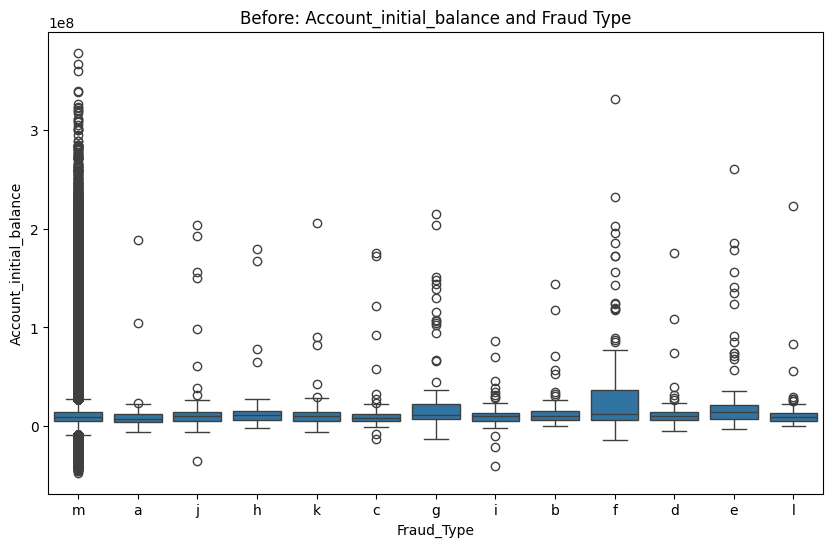

AFTER


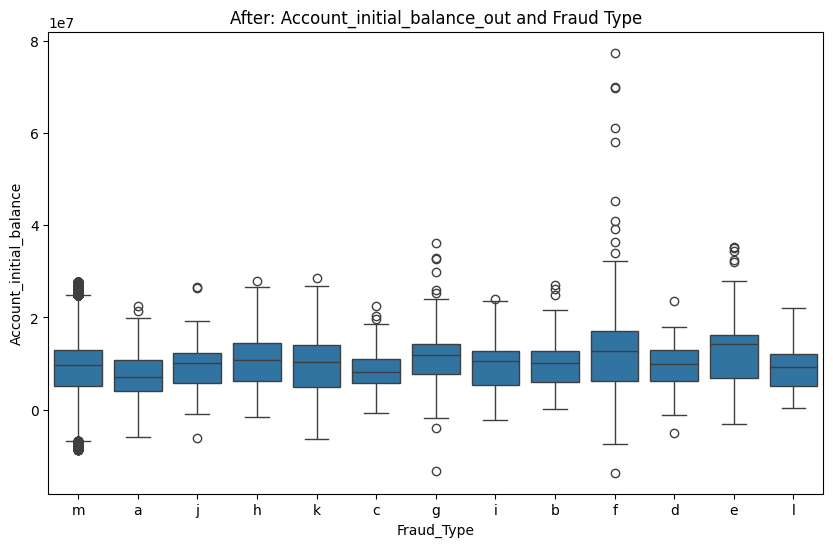

In [ ]:
# 거래전 잔액
plot_numerical('Account_initial_balance')

BEFORE


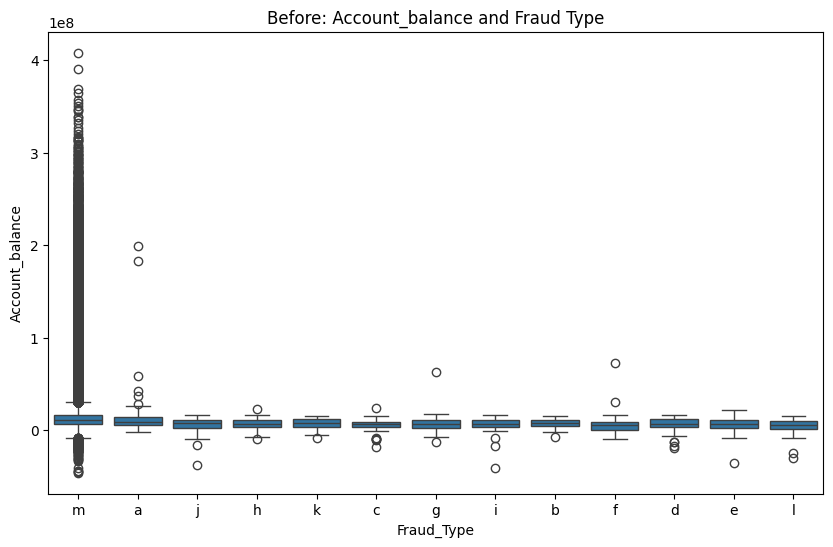

AFTER


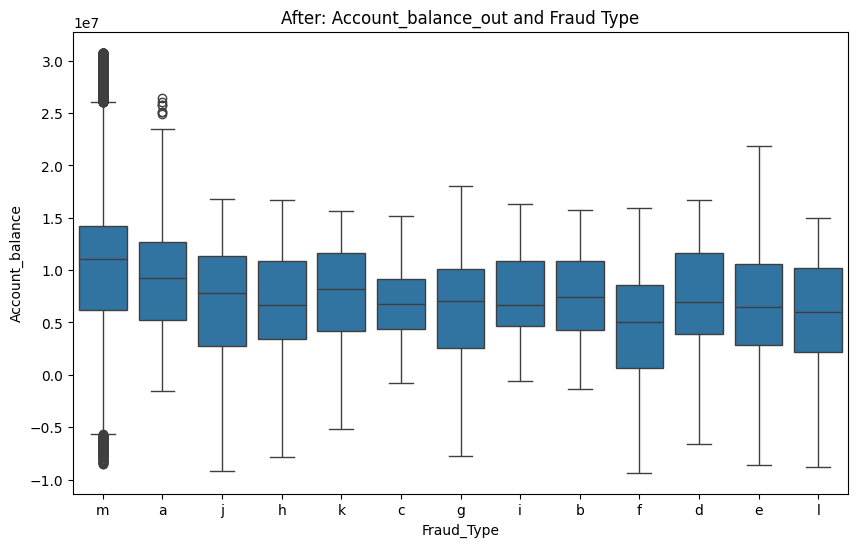

In [ ]:
# 거래후 잔액
plot_numerical('Account_balance')

BEFORE


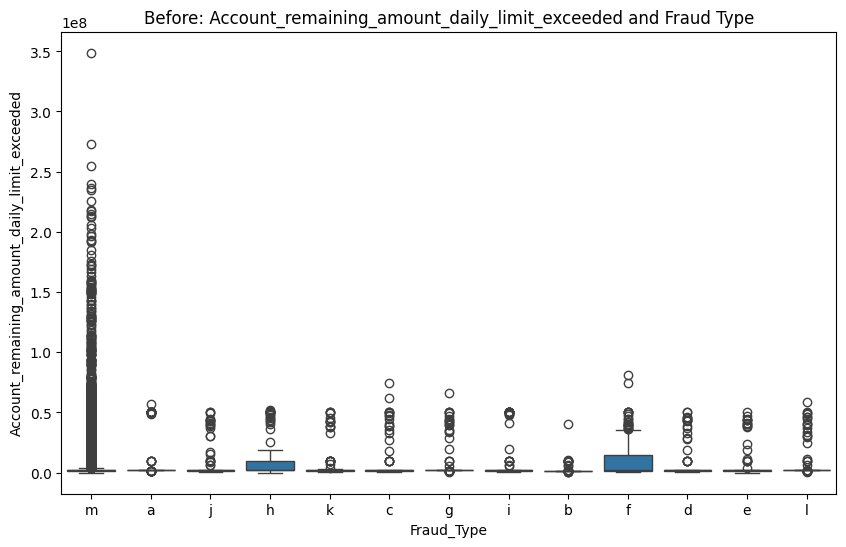

AFTER


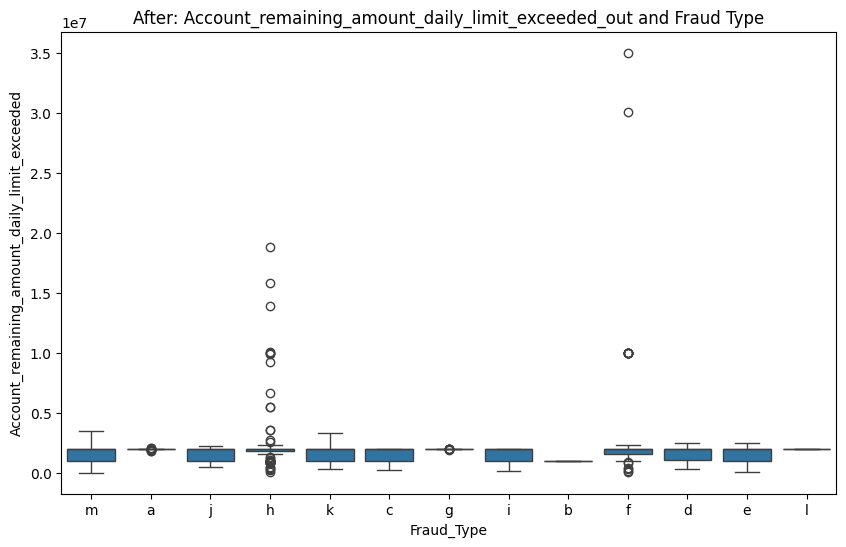

In [ ]:
# 1일 거래 한도 잔여액
plot_numerical('Account_remaining_amount_daily_limit_exceeded')

BEFORE


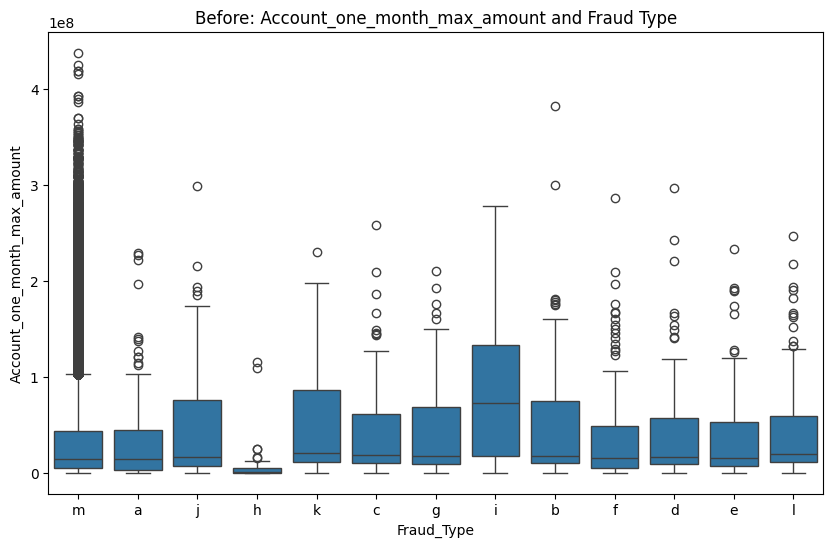

AFTER


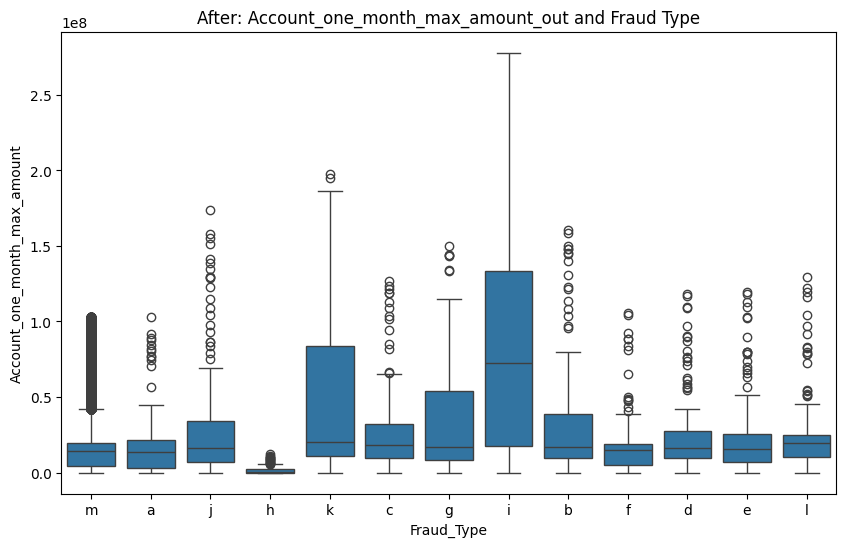

In [ ]:
# 1개월 거래내역 중 최대 이체(출금) 금액
plot_numerical('Account_one_month_max_amount')

BEFORE


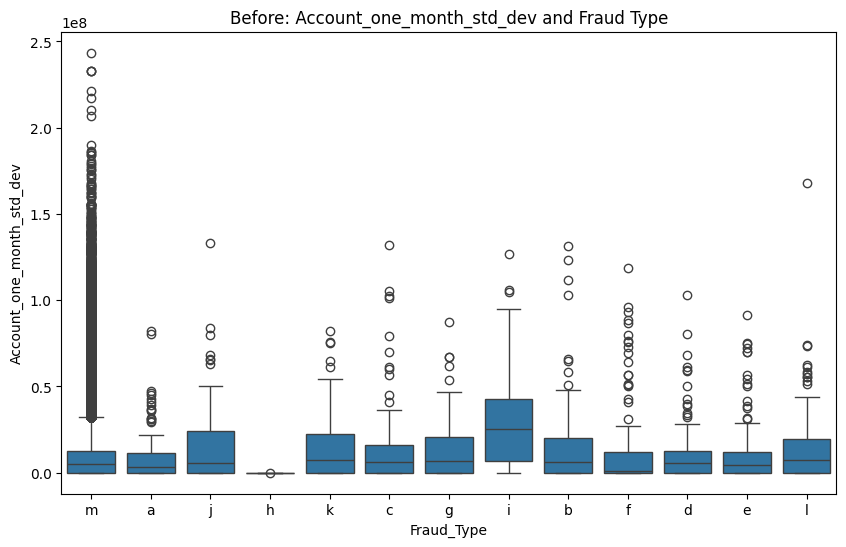

AFTER


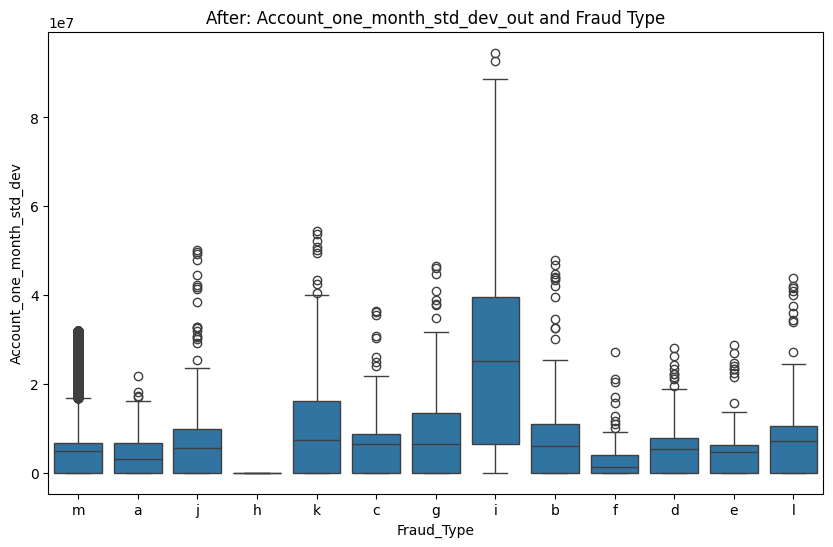

In [ ]:
# 1개월 거래내역 이체(출금) 금액 표준편차(중앙값)
plot_numerical('Account_one_month_std_dev')

BEFORE


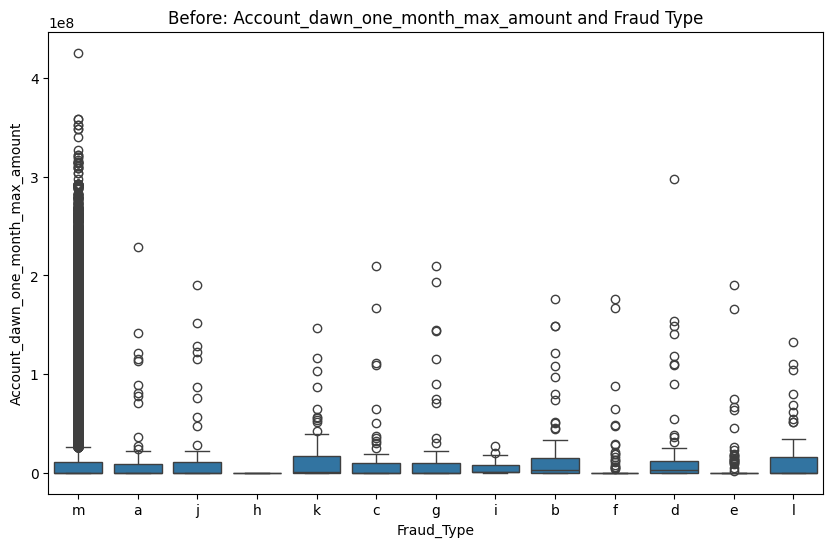

AFTER


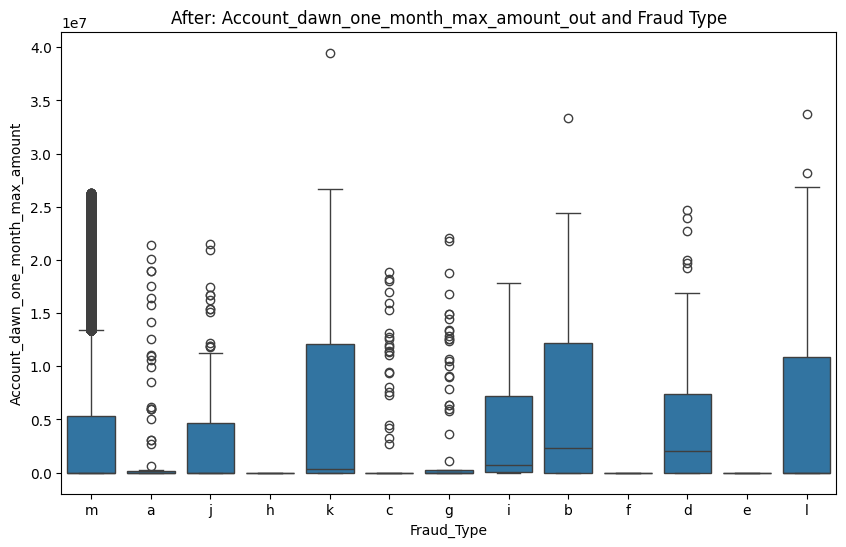

In [ ]:
# 1개월 새벽 거래내역 중 최대 이체(출금) 금액
plot_numerical('Account_dawn_one_month_max_amount')

BEFORE


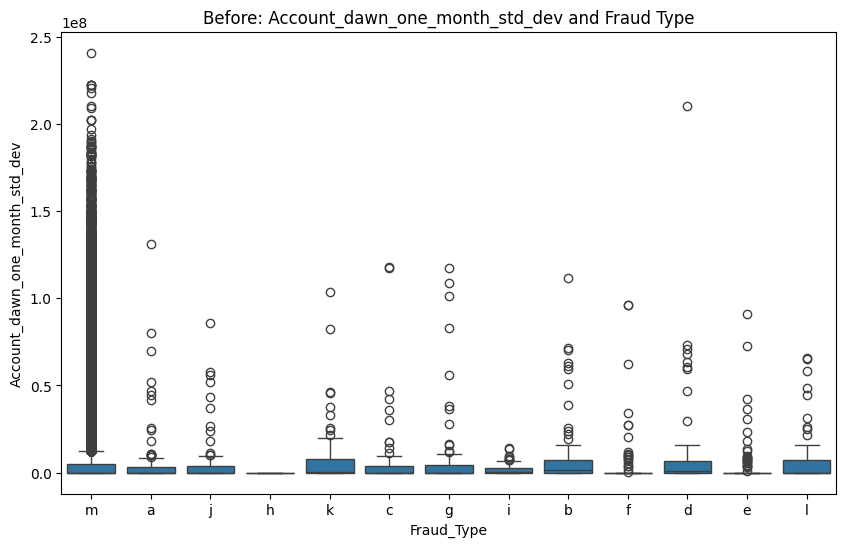

AFTER


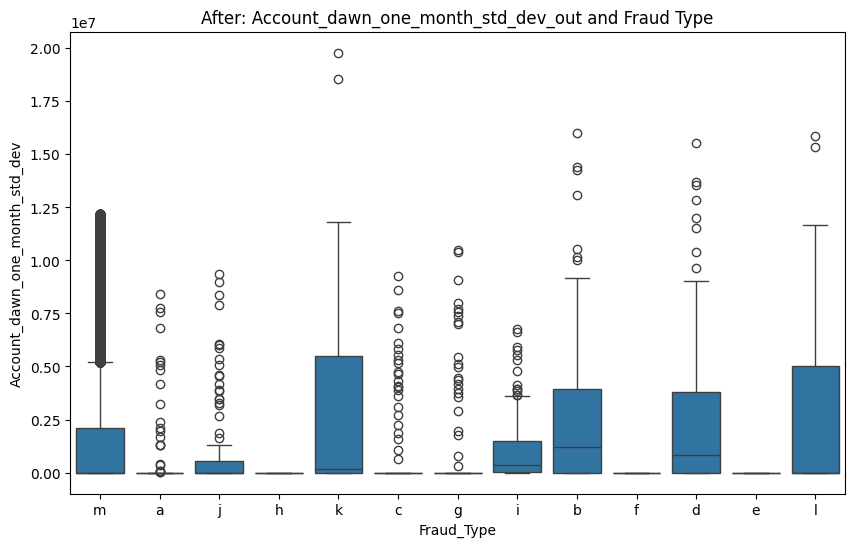

In [ ]:
# 1개월 새벽 거래내역 이체(출금) 금액 표준편처(중앙값)
plot_numerical('Account_dawn_one_month_std_dev')

BEFORE


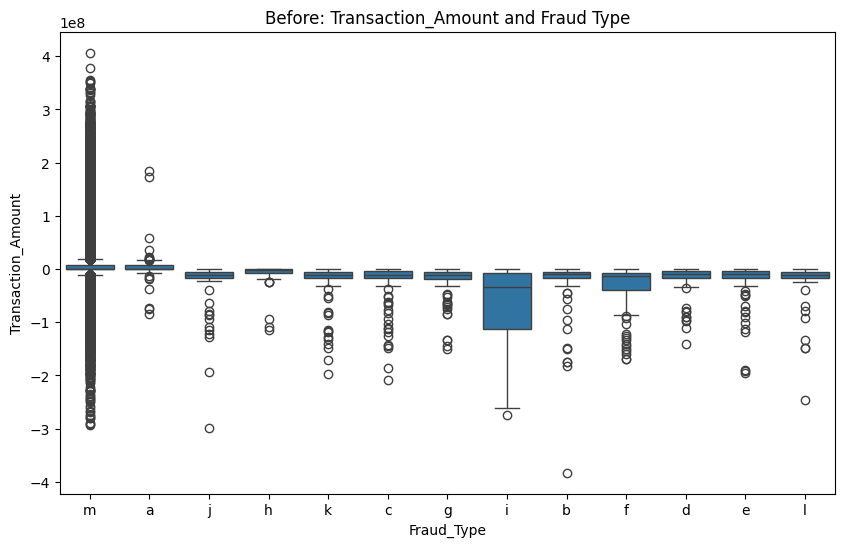

AFTER


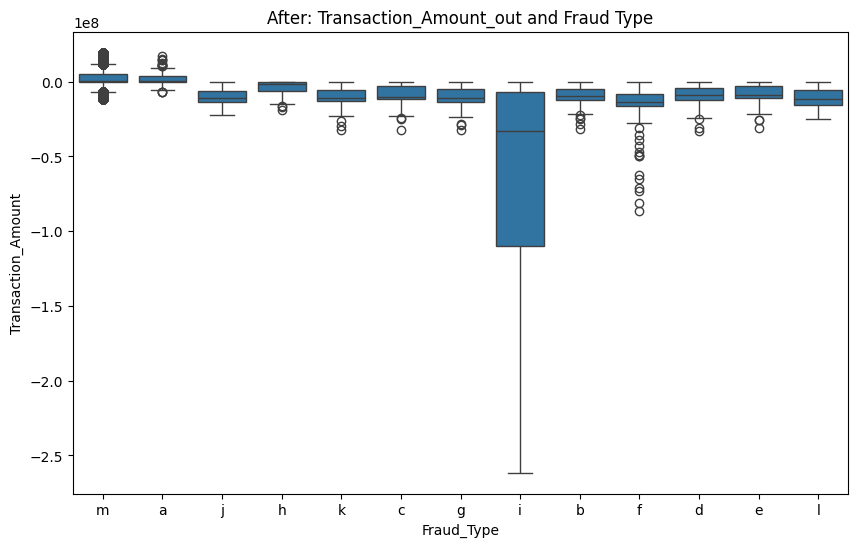

In [ ]:
# 이체 금액
plot_numerical('Transaction_Amount')

# 데이터 이상치 정리 (전처리)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'

train_all = pd.read_csv(path + "train.csv")
test_all = pd.read_csv(path + "test.csv")

train = train_all.drop(columns="ID")

In [ ]:
# Time_difference 컬럼을 총 초로 변환 및 이상치 처리
timedeltas = pd.to_timedelta(train.Time_difference)
average_time = timedeltas.mean()
average_time_formatted = str(pd.to_timedelta(average_time)).split('.')[0]
train.loc[13972, 'Time_difference'] = average_time_formatted
print(average_time_formatted)

train['Time_difference_seconds'] = pd.to_timedelta(train['Time_difference']).dt.total_seconds()


# account 관련 값들 이상치 처리하기
for x in ['Transaction_Amount', 'Account_initial_balance', 'Account_balance', 'Account_remaining_amount_daily_limit_exceeded',
          'Account_one_month_max_amount', 'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount', 'Time_difference_seconds',
          'Account_dawn_one_month_std_dev']:
    train = replace_outliers_with_median(train, 'Fraud_Type', x)


8 days 18:30:56


In [ ]:
# 저장
save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data'
train.to_csv(save_path + '/1_all_pre_syn.csv', index=False)

In [ ]:
saved_train = pd.read_csv(save_path + '/1_all_pre_syn.csv')
saved_train[saved_train.Time_difference_seconds <= 0]

,Customer_Birthyear,Customer_Gender,Customer_personal_identifier,Customer_identification_number,Customer_registration_datetime,Customer_credit_rating,Customer_flag_change_of_authentication_1,Customer_flag_change_of_authentication_2,Customer_flag_change_of_authentication_3,Customer_flag_change_of_authentication_4,...,Last_bank_branch_transaction_datetime,Flag_deposit_more_than_tenMillion,Unused_account_status,Recipient_account_suspend_status,Number_of_transaction_with_the_account,Transaction_history_with_the_account,First_time_iOS_by_vulnerable_user,Fraud_Type,Transaction_resumed_date,Time_difference_seconds
